# 1. Introduction and Motivation

Physics-Informed Neural Networks (PINNs) are a class of deep learning models that integrate physical laws—expressed as partial differential equations (PDEs)—into the training process of neural networks. Unlike traditional data-driven models, which rely solely on observational data, PINNs incorporate domain knowledge to enforce physical consistency across the entire domain.

This notebook explores the use of PINNs for solving the wave equation and evaluates their ability to generalise beyond the training domain. Three main variants are implemented:

- A classical PINN for the 1D and 3D wave equations
- A PINN incorporating periodic boundary conditions (PBCs)
- A nonlinear PINN with a cubic term $u^3$

The wave equation is chosen as a baseline due to its analytical tractability and widespread applicability in both physics and finance. Each model is evaluated on both interpolation (in-domain) and extrapolation (out-of-domain) regimes using quantitative metrics like Mean Squared Error (MSE) and visual comparisons.

The structure of this notebook mirrors the analytical and experimental components of the dissertation *"Are Physics-Informed Neural Networks the Future of Financial Modelling?"* and builds upon the methodology established in prior literature [1, 2].

---

**References:**

[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear PDEs. *Journal of Computational Physics*, 378, 686–707.  
[2] Karniadakis, G. E., Kevrekidis, I. G., Lu, L., Perdikaris, P., Wang, S., & Yang, L. (2021). Physics-informed machine learning. *Nature Reviews Physics*, 3(6), 422–440.


## 2. Loss Function Formulation

Physics-Informed Neural Networks (PINNs) solve partial differential equations (PDEs) by embedding the equation and its constraints directly into the loss function of a neural network.

We define a total loss function that combines contributions from:
- The PDE residual (interior points)
- Initial condition (IC) mismatch
- Boundary condition (BC) mismatch

The total loss function is:

$$
\mathcal{L}_{\text{total}} = \lambda_{\text{PDE}} \mathcal{L}_{\text{PDE}} + \lambda_{\text{IC}} \mathcal{L}_{\text{IC}} + \lambda_{\text{BC}} \mathcal{L}_{\text{BC}}
$$

Each loss component is defined as follows:

- **PDE loss**: Measures how well the predicted function $u(x,t)$ satisfies the PDE.
- **IC loss**: Measures deviation from the initial condition at $t = 0$.
- **BC loss**: Measures mismatch at the spatial domain boundaries, e.g., $x = 0$ and $x = 1$.

These components are evaluated at randomly sampled collocation points using **automatic differentiation** to compute derivatives with respect to inputs. This strategy enforces physical consistency without requiring labelled data throughout the domain.


In [5]:
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers):
        super(PINN, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())

        # Hidden layers
        for _ in range(num_hidden_layers - 1):  # ← Fix: use -1 here
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
        
def pinn_loss(model, X_f, X_ic, u_ic, X_bc, u_bc, c=1.0, beta=0.0):
    """
    Compute the total PINN loss including PDE, IC, and BC residuals.
    
    Parameters:
    - model: neural network model predicting u(x,t)
    - X_f: collocation points for PDE residual
    - X_ic: initial condition points
    - u_ic: initial condition values
    - X_bc: boundary condition points
    - u_bc: boundary condition values
    - c: wave speed
    - beta: nonlinearity coefficient (0 for classical, >0 for nonlinear)

    Returns:
    - total_loss: combined loss
    """
    # PDE Residual
    X_f.requires_grad = True
    u = model(X_f)
    u_t = torch.autograd.grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_tt = torch.autograd.grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1]
    u_x = torch.autograd.grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_xx = torch.autograd.grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]

    f_pde = u_tt - c**2 * u_xx + beta * u**3
    loss_pde = torch.mean(f_pde**2)

    # Initial Condition Loss
    u_pred_ic = model(X_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    # Boundary Condition Loss
    u_pred_bc = model(X_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    return loss_pde + loss_ic + loss_bc


# 3. Classical PINN for the 1D Wave Equation

We begin by solving the 1D wave equation using a classical PINN. The wave equation is:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

We define initial conditions:

- Displacement: $ u(x,0) = \sin(\pi x) $
- Velocity: $ \frac{\partial u}{\partial t}(x,0) = 0 $

And Dirichlet boundary conditions:

$$
u(0,t) = u(1,t) = 0
$$

These conditions yield an exact analytical solution:

$$
u(x,t) = \sin(\pi x)\cos(\pi c t)
$$

We will train a neural network to approximate this solution over the domain $ x \in [0,1] $, $ t \in [0,1] $, using the PINN loss function defined earlier.


In [2]:
import torch
import numpy as np

# Domain boundaries
x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0
c = 1.0  # wave speed

# Generate collocation points (interior)
N_f = 10000
X_f = torch.tensor(np.random.rand(N_f, 2), dtype=torch.float32)
X_f[:, 0] = X_f[:, 0] * (x_max - x_min) + x_min  # x
X_f[:, 1] = X_f[:, 1] * (t_max - t_min) + t_min  # t

# Initial condition: u(x,0) = sin(pi x), ∂u/∂t = 0
N_ic = 200
x_ic = torch.linspace(x_min, x_max, N_ic).reshape(-1, 1)
t_ic = torch.zeros_like(x_ic)
X_ic = torch.cat([x_ic, t_ic], dim=1)
u_ic = torch.sin(np.pi * x_ic)

# Boundary conditions: u(0,t) = u(1,t) = 0
N_bc = 200
t_bc = torch.linspace(t_min, t_max, N_bc).reshape(-1, 1)
x0 = torch.full_like(t_bc, x_min)
x1 = torch.full_like(t_bc, x_max)

X_bc = torch.cat([
    torch.cat([x0, t_bc], dim=1),
    torch.cat([x1, t_bc], dim=1)
], dim=0)
u_bc = torch.zeros_like(X_bc[:, 0:1])


## 4. Model Architecture and Training (1D Wave Equation)

We define a fully connected feedforward neural network (FNN) to approximate the solution $u(x,t)$. The model takes $x$ and $t$ as input and outputs a scalar prediction $u$.

The training optimises the combined PINN loss function (PDE + initial condition + boundary condition losses) using the Adam optimiser.

We'll monitor convergence with loss curves and validate against the analytical solution $u(x,t) = \sin(\pi x) \cos(\pi c t)$.


In [3]:
import torch.nn as nn
import torch.optim as optim

# Define PINN architecture
class PINN(nn.Module):
  def __init__(self, layers):
    super(PINN, self).__init__()
    self.activation = nn.Tanh()
    self.layers = nn.ModuleList()
    for i in range(len(layers) - 1):
      self.layers.append(nn.Linear(layers[i], layers[i+1]))

  def forward(self, x):
    for i in range(len(self.layers) - 1):
      x = self.activation(self.layers[i](x))
    return self.layers[-1](x)

# Create model
layers = [2, 64, 64, 64, 1]  # input: (x, t), output: u
model = PINN(layers)

# Optimiser
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## 5. Optimisation Strategy

We train the neural network using the Adam optimiser, a variant of stochastic gradient descent (SGD) that adapts the learning rate for each parameter based on the first and second moments of the gradients.

Adam has shown strong performance in training deep networks, particularly in non-convex settings like PINNs. It combines the advantages of momentum and RMSProp to accelerate convergence and stabilise updates.

We use a learning rate of $10^{-3}$ and monitor the total loss over training epochs.

### Why Train for 5000 Epochs?

Physics-Informed Neural Networks (PINNs) often require longer training durations compared to standard neural networks due to the complexity of their loss structure and optimisation process.

#### Reasons for Extended Training

- **Multiple loss components**: PINNs minimise a combination of:
  - PDE residual loss
  - Initial condition loss
  - Boundary condition loss  
  These must all converge simultaneously, which slows optimisation.

- **No labels for most points**: Unlike supervised learning, PINNs learn from collocation points without ground-truth labels. They must infer the correct behaviour solely from the physical equations.

- **Low data regimes**: The model trains on a relatively small set of points (e.g. 10k–20k collocation points), so it needs more time to generalise accurately.

- **Stability issues**: PINNs are sensitive to learning rates, initialisation, and relative weightings of different loss components. Extended training helps stabilise convergence.

#### Practical Choice of 5000 Epochs

In this notebook, we use 5000 epochs to allow:
- Sufficient convergence of all loss components
- Clear visualisation of the loss curve over time
- Alignment with best practices from literature (e.g., Raissi et al. 2019 [1], Wang et al. 2022 [2])

In practice, convergence might plateau earlier. You can inspect the loss plot and terminate training early if needed.

---

**References**  
[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear PDEs. *Journal of Computational Physics*, 378, 686–707.  
[2] Wang, S., Teng, Y., & Perdikaris, P. (2022). Understanding and mitigating gradient flow pathologies in physics-informed neural networks. *SIAM Journal on Scientific Computing*, 44(1), A116–A148.



In [4]:
loss_history = []

def train(model, epochs, X_f, X_ic, u_ic, X_bc, u_bc, optimizer, beta=0.0):
  model.train()
  for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, X_f, X_ic, u_ic, X_bc, u_bc, c=1.0, beta=beta)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
      print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


In [5]:
# Train the model
train(model, epochs=5000, X_f=X_f, X_ic=X_ic, u_ic=u_ic, X_bc=X_bc, u_bc=u_bc, optimizer=optimizer)


Epoch 0: Loss = 0.350435
Epoch 500: Loss = 0.002495
Epoch 1000: Loss = 0.000498
Epoch 1500: Loss = 0.000140
Epoch 2000: Loss = 0.000084
Epoch 2500: Loss = 0.000054
Epoch 3000: Loss = 0.000061
Epoch 3500: Loss = 0.000028
Epoch 4000: Loss = 0.000024
Epoch 4500: Loss = 0.000019


## 6. Evaluation and Visualisation

After training, we evaluate the model's performance by comparing its predictions to the analytical solution of the 1D wave equation.

The analytical solution for the setup used is:

$$
u(x,t) = \sin(\pi x) \cos(\pi t)
$$

We compute the predicted solution on a dense test grid over the spatiotemporal domain $[0,1] \times [0,1]$ and visualise both the predicted and analytical surfaces, along with their pointwise error.


In [6]:
# Generate dense test grid
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)
X_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Model predictions
model.eval()
with torch.no_grad():
    u_pred = model(X_test_tensor).numpy().flatten()

# Analytical solution
u_exact = np.sin(np.pi * X_test[:, 0]) * np.cos(np.pi * X_test[:, 1])

# Compute error
error = np.abs(u_exact - u_pred)

# Reshape for plotting
U_pred = u_pred.reshape(100, 100)
U_exact = u_exact.reshape(100, 100)
Error = error.reshape(100, 100)


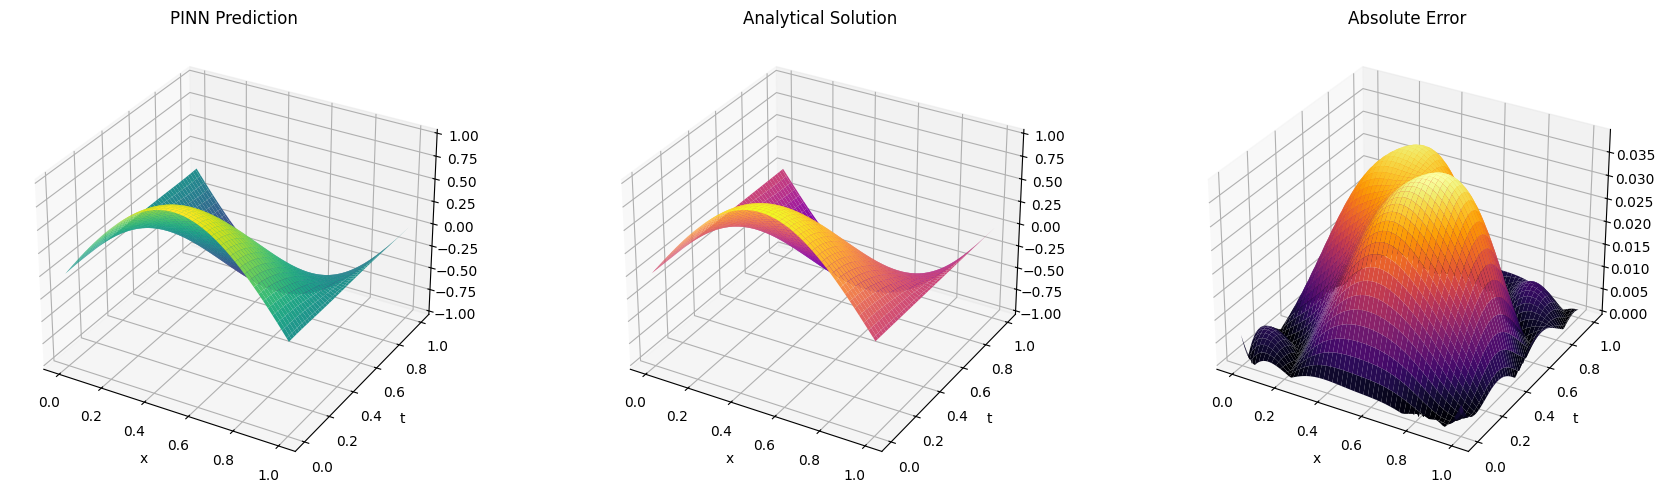

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 5))

# Predicted Surface
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(X, T, U_pred, cmap='viridis')
ax.set_title("PINN Prediction")
ax.set_xlabel("x")
ax.set_ylabel("t")

# Analytical Surface
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(X, T, U_exact, cmap='plasma')
ax.set_title("Analytical Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")

# Error Surface
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(X, T, Error, cmap='inferno')
ax.set_title("Absolute Error")
ax.set_xlabel("x")
ax.set_ylabel("t")

plt.tight_layout()

# Save the figure
plt.savefig("wave_1d_surface_comparison.png", dpi=300, bbox_inches="tight")

plt.show()


## 7. Extension to 3D Wave Equation

To test the scalability of the classical PINN, we extend the model to solve the 3D wave equation:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} \right)
$$

This partial differential equation governs wave propagation in three spatial dimensions and time. Implementing this with a PINN increases the input dimensionality to four variables \((x, y, z, t)\) and requires significantly more collocation and condition points.

We define a known analytical solution for validation:

$$
u(x, y, z, t) = \sin(\pi x)\sin(\pi y)\sin(\pi z)\cos(\pi t)
$$

The model architecture remains the same but is extended to accept four inputs. This enables us to verify how classical PINNs perform under higher-dimensional PDEs, which is relevant when scaling PINNs to more complex financial models.

We also compare performance against the 1D case using visualisation and error metrics.


In [14]:
# Reduced for memory safety
N_f = 5000
N_ic = 500
N_bc = 1000
c = 1.0

# Sample collocation points
X_f = np.random.rand(N_f, 4)  # [x, y, z, t] ∈ [0, 1]
X_ic = np.random.rand(N_ic, 4)
X_ic[:, 3] = 0  # t = 0

# Initial condition: u(x,y,z,0) = sin(pi x) sin(pi y) sin(pi z)
u_ic = np.sin(np.pi * X_ic[:, 0]) * np.sin(np.pi * X_ic[:, 1]) * np.sin(np.pi * X_ic[:, 2])
u_ic = torch.tensor(u_ic.reshape(-1, 1), dtype=torch.float32)

# Boundary conditions (randomly select x, y, or z = 0 or 1)
X_bc = np.random.rand(N_bc, 4)
random_dim = np.random.randint(0, 3, N_bc)
random_face = np.random.choice([0, 1], N_bc)
X_bc[np.arange(N_bc), random_dim] = random_face
u_bc = np.zeros((N_bc, 1))

# Convert all to tensors
X_f_tensor = torch.tensor(X_f, dtype=torch.float32)
X_ic_tensor = torch.tensor(X_ic, dtype=torch.float32)
X_bc_tensor = torch.tensor(X_bc, dtype=torch.float32)
u_bc_tensor = torch.tensor(u_bc, dtype=torch.float32)


## 8. Defining the 3D PINN Model

To solve the 3D wave equation, we use a fully connected feedforward neural network with four input variables: $x, y, z, t$. The output is a scalar $u(x, y, z, t)$ representing the wave displacement. The network uses hidden layers with nonlinear activation functions to approximate the solution.

We retain the same structure as in the 1D case, but extend the input dimension to four. This architecture is intentionally kept simple to isolate the effect of dimensionality on PINN performance.

The training objective minimises the PDE residual at interior points and enforces initial and boundary conditions using a combined loss function.


In [15]:
# Define the 3D PINN architecture
class PINN3D(nn.Module):
    def __init__(self):
        super(PINN3D, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
model_3d = PINN3D()

# Define optimizer
optimizer_3d = torch.optim.Adam(model_3d.parameters(), lr=1e-3)


## 9. PINN Loss Function and Training for the 3D Model

The loss function for the 3D PINN follows the same principles as the 1D case. It combines:

- **PDE Residual Loss**: Enforcing the 3D wave equation inside the domain.
- **Initial Condition Loss**: Penalising deviation from the known initial displacement.
- **Boundary Condition Loss**: Ensuring \( u = 0 \) at the domain boundaries.

The PDE residual is computed using automatic differentiation with respect to \(x, y, z,\) and \(t\). We use the Adam optimiser and track the loss across epochs for convergence analysis.


In [16]:
loss_history_3d = []

def pinn_loss_3d(model, X_f, X_ic, u_ic, X_bc, u_bc, c=1.0):
    X_f.requires_grad = True
    u = model(X_f)

    grads = torch.autograd.grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:, 3]
    u_tt = torch.autograd.grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 3]

    u_x = grads[:, 0]
    u_xx = torch.autograd.grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_y = grads[:, 1]
    u_yy = torch.autograd.grad(u_y, X_f, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    u_z = grads[:, 2]
    u_zz = torch.autograd.grad(u_z, X_f, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 2]

    f_pde = u_tt - c**2 * (u_xx + u_yy + u_zz)
    loss_pde = torch.mean(f_pde**2)

    u_pred_ic = model(X_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    u_pred_bc = model(X_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    return loss_pde + loss_ic + loss_bc

def train_3d(model, epochs, X_f, X_ic, u_ic, X_bc, u_bc, optimizer, c=1.0):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pinn_loss_3d(model, X_f, X_ic, u_ic, X_bc, u_bc, c=c)
        loss.backward()
        optimizer.step()

        loss_history_3d.append(loss.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


## 10. Training the 3D PINN Model

We now train the 3D Physics-Informed Neural Network using the Adam optimiser. This process will solve the 3D wave equation over a 4D input space: \( x, y, z, t \). Training convergence is monitored by plotting the log-scale loss curve over epochs.

The model is expected to learn the following solution:

$$
u(x, y, z, t) = \sin(\pi x)\sin(\pi y)\sin(\pi z)\cos(\pi t)
$$

This analytical form will later be used to evaluate the predictive accuracy of the trained PINN on unseen data.

In [19]:
# Define 3D model
model_3d = PINN3D()

# Optimiser
optimizer_3d = torch.optim.Adam(model_3d.parameters(), lr=1e-3)

# Train the 3D model
train_3d(model_3d, epochs=5000, 
         X_f=X_f_tensor, 
         X_ic=X_ic_tensor, 
         u_ic=u_ic, 
         X_bc=X_bc_tensor, 
         u_bc=torch.tensor(u_bc, dtype=torch.float32),
         optimizer=optimizer_3d)


Epoch 0: Loss = 0.098666
Epoch 500: Loss = 0.031396
Epoch 1000: Loss = 0.019586
Epoch 1500: Loss = 0.014036
Epoch 2000: Loss = 0.011032
Epoch 2500: Loss = 0.008876
Epoch 3000: Loss = 0.007580
Epoch 3500: Loss = 0.006763
Epoch 4000: Loss = 0.006079
Epoch 4500: Loss = 0.005940


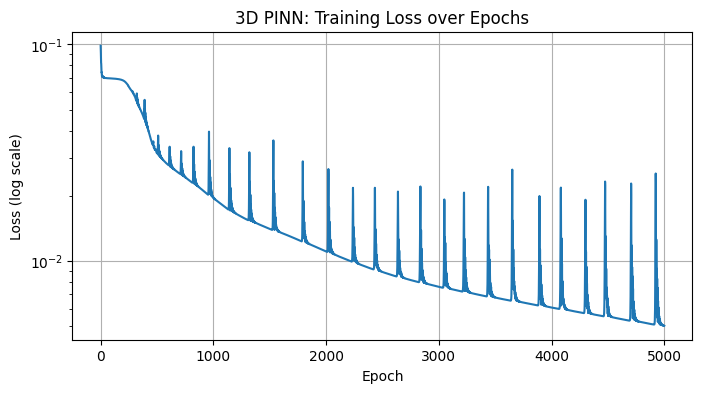

In [21]:
import os
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(8, 4))
plt.plot(loss_history_3d)
plt.yscale("log")
plt.title("3D PINN: Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.savefig("figures/3d_wave_loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()


## 11. Evaluating the 3D PINN Performance

To assess the accuracy of the trained 3D PINN, we compare its predictions against the analytical solution:

$$
u(x, y, z, t) = \sin(\pi x)\sin(\pi y)\sin(\pi z)\cos(\pi t)
$$

We use a set of unseen test points to compute the Mean Squared Error (MSE). This evaluation quantifies both interpolation accuracy within the training domain and the model’s ability to generalise.


In [22]:
# Generate test points
N_test = 2000
X_test = np.random.rand(N_test, 4)  # x, y, z, t ∈ [0, 1]

# Ground truth
u_exact = np.sin(np.pi * X_test[:, 0]) * np.sin(np.pi * X_test[:, 1]) * np.sin(np.pi * X_test[:, 2]) * np.cos(np.pi * X_test[:, 3])
u_exact = u_exact.reshape(-1, 1)

# Model prediction
model_3d.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    u_pred = model_3d(X_test_tensor).numpy()

# Compute MSE
mse_3d = np.mean((u_pred - u_exact) ** 2)
print(f"3D PINN Mean Squared Error (MSE): {mse_3d:.6e}")


3D PINN Mean Squared Error (MSE): 4.794767e-02


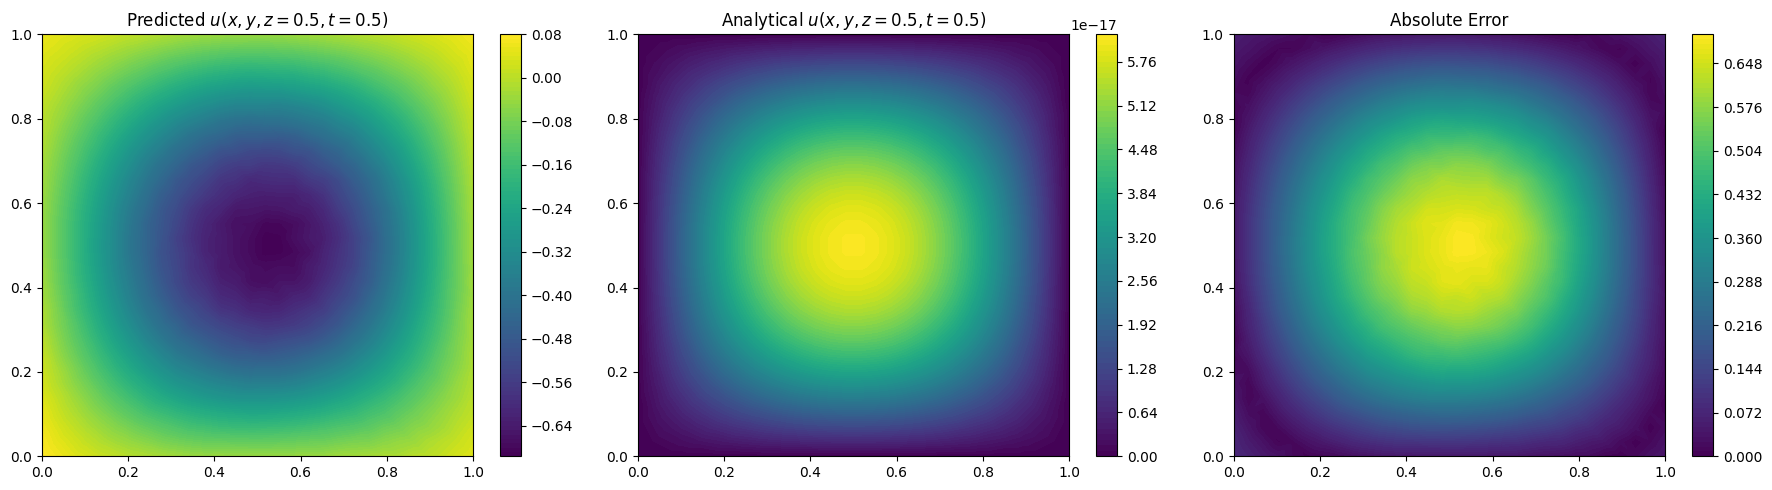

In [23]:
# Generate a 3D slice at fixed t=0.5
fixed_t = 0.5
grid_size = 30

x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
z = np.linspace(0, 1, grid_size)
X, Y, Z = np.meshgrid(x, y, z)
T = np.full_like(X, fixed_t)

X_plot = np.stack([X.flatten(), Y.flatten(), Z.flatten(), T.flatten()], axis=1)
X_tensor_plot = torch.tensor(X_plot, dtype=torch.float32)

# Predict with trained 3D PINN
model_3d.eval()
with torch.no_grad():
    u_pred_plot = model_3d(X_tensor_plot).cpu().numpy().flatten()

# Analytical solution
u_true_plot = np.sin(np.pi * X_plot[:, 0]) * np.sin(np.pi * X_plot[:, 1]) * np.sin(np.pi * X_plot[:, 2]) * np.cos(np.pi * fixed_t)

# Absolute error
error = np.abs(u_pred_plot - u_true_plot)

# Plot a 2D slice at z ≈ 0.5
slice_mask = np.isclose(X_plot[:, 2], 0.5, atol=0.05)
X_slice = X_plot[slice_mask]
u_pred_slice = u_pred_plot[slice_mask]
u_true_slice = u_true_plot[slice_mask]
error_slice = error[slice_mask]

import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Triangular mesh for irregular grids
triang = tri.Triangulation(X_slice[:, 0], X_slice[:, 1])

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.tricontourf(triang, u_pred_slice, levels=100)
plt.title('Predicted $u(x, y, z=0.5, t=0.5)$')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.tricontourf(triang, u_true_slice, levels=100)
plt.title('Analytical $u(x, y, z=0.5, t=0.5)$')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.tricontourf(triang, error_slice, levels=100)
plt.title('Absolute Error')
plt.colorbar()

plt.tight_layout()
plt.savefig("figures/wave_3d_surface.png", dpi=300, bbox_inches="tight")
plt.show()


## 12. Incorporating Periodic Boundary Conditions (PBCs)

Periodic boundary conditions are used to model systems that exhibit repeating or cyclic behaviour, such as wave propagation on a loop or seasonally varying financial processes. Instead of fixing boundary values (Dirichlet conditions), periodic boundaries require the solution and its spatial derivative to be equal at the edges:

$$
u(0, t) = u(1, t), \quad \frac{\partial u}{\partial x}(0, t) = \frac{\partial u}{\partial x}(1, t)
$$

These conditions introduce a global constraint on the solution space and can improve the PINN's ability to generalise near boundaries.

To implement this in a 1D wave PINN, we:

- Sample boundary pairs at $x=0$ and $x=1$
- Compute the difference in predicted $u$ and $\frac{\partial u}{\partial x}$ at these locations
- Add the squared differences to the total loss as a periodic constraint

This variant helps the model learn smooth and globally coherent functions.


In [23]:
def pinn_loss_pbc(model, X_f, X_ic, u_ic, X_bc0, X_bc1, c=1.0, beta=0.0):
    """
    Compute total loss for PINN with periodic boundary conditions (PBC).
    
    X_bc0: boundary points at x = 0
    X_bc1: corresponding boundary points at x = 1
    """
    X_f.requires_grad = True
    u = model(X_f)

    u_t = torch.autograd.grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_tt = torch.autograd.grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1]
    u_x = torch.autograd.grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_xx = torch.autograd.grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]

    f_pde = u_tt - c**2 * u_xx + beta * u**3
    loss_pde = torch.mean(f_pde**2)

    # Initial condition loss
    u_pred_ic = model(X_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    # PBC loss
    u_bc0 = model(X_bc0)
    u_bc1 = model(X_bc1)

    u_x_bc0 = torch.autograd.grad(u_bc0, X_bc0, grad_outputs=torch.ones_like(u_bc0), create_graph=True)[0][:, 0]
    u_x_bc1 = torch.autograd.grad(u_bc1, X_bc1, grad_outputs=torch.ones_like(u_bc1), create_graph=True)[0][:, 0]

    loss_pbc_u = torch.mean((u_bc0 - u_bc1)**2)
    loss_pbc_dx = torch.mean((u_x_bc0 - u_x_bc1)**2)

    loss_pbc_total = loss_pbc_u + loss_pbc_dx

    return loss_pde + loss_ic + loss_pbc_total


## 13. Training the PINN with Periodic Boundary Conditions

To train the PINN using periodic boundary conditions (PBCs), we sample boundary pairs from the left ($x=0$) and right ($x=1$) edges of the spatial domain. These are used in the custom loss function to enforce periodicity in both the predicted solution $u(x, t)$ and its spatial derivative $\frac{\partial u}{\partial x}$.

We keep the same model architecture and number of training epochs for comparability. Loss history is logged and plotted to assess convergence.


In [24]:
# Sample periodic boundary points
N_bc = 1000
t_bc = np.random.rand(N_bc, 1)
X_bc0_np = np.hstack((np.zeros_like(t_bc), t_bc))  # x = 0
X_bc1_np = np.hstack((np.ones_like(t_bc), t_bc))   # x = 1

X_bc0 = torch.tensor(X_bc0_np, dtype=torch.float32, requires_grad=True)
X_bc1 = torch.tensor(X_bc1_np, dtype=torch.float32, requires_grad=True)

# Reuse collocation and IC points
# (Assume X_f, X_ic, u_ic already defined from previous section)

# Re-define 1D wave setup for PBC training
N_f = 5000
N_ic = 1000

x_f = np.random.rand(N_f, 1)
t_f = np.random.rand(N_f, 1)
X_f = np.hstack((x_f, t_f))

x_ic = np.random.rand(N_ic, 1)
t_ic = np.zeros_like(x_ic)
X_ic = np.hstack((x_ic, t_ic))
u_ic_vals = np.sin(np.pi * x_ic)

# Convert to tensors
X_f_tensor = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)
X_ic_tensor = torch.tensor(X_ic, dtype=torch.float32, requires_grad=True)
u_ic = torch.tensor(u_ic_vals, dtype=torch.float32)

# Define new model for PBCmodel_pbc = PINN(2, 50, 1, 4)
model_pbc = PINN(2, 50, 1, 4)
optimizer_pbc = torch.optim.Adam(model_pbc.parameters(), lr=1e-3)

loss_history_pbc = []

optimizer_pbc = torch.optim.Adam(model_pbc.parameters(), lr=1e-3)

loss_history_pbc = []

def train_pbc(model, epochs, X_f, X_ic, u_ic, X_bc0, X_bc1, optimizer, beta=0.0):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pinn_loss_pbc(model, X_f, X_ic, u_ic, X_bc0, X_bc1, c=1.0, beta=beta)
        loss.backward()
        optimizer.step()
        loss_history_pbc.append(loss.item())

        if epoch % 500 == 0:
            print(f"[PBC] Epoch {epoch}: Loss = {loss.item():.6f}")

loss_history_pbc = []

# Train
train_pbc(model_pbc, epochs=5000, 
          X_f=X_f_tensor, 
          X_ic=X_ic_tensor, 
          u_ic=u_ic,
          X_bc0=X_bc0, 
          X_bc1=X_bc1, 
          optimizer=optimizer_pbc)


[PBC] Epoch 0: Loss = 0.395733
[PBC] Epoch 500: Loss = 0.092324
[PBC] Epoch 1000: Loss = 0.091215
[PBC] Epoch 1500: Loss = 0.064476
[PBC] Epoch 2000: Loss = 0.033394
[PBC] Epoch 2500: Loss = 0.013039
[PBC] Epoch 3000: Loss = 0.008670
[PBC] Epoch 3500: Loss = 0.006561
[PBC] Epoch 4000: Loss = 0.005854
[PBC] Epoch 4500: Loss = 0.004922


## 14. Visualising PBC Training and Generalisation

After training, we visualise the loss convergence for the periodic PINN and compare its performance with the classical PINN trained earlier.

To evaluate the benefit of periodic boundary conditions, we compute the Mean Squared Error (MSE) on extrapolated domains (out-of-domain test points). The goal is to see whether the periodic structure improves generalisation near the domain boundaries.

A side-by-side plot of predicted $u(x,t)$ solutions for both models helps illustrate differences in smoothness and extrapolation error.


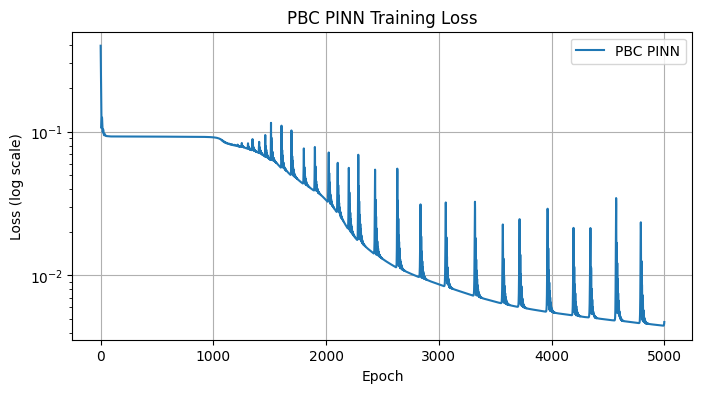

Extrapolation MSE (Classical PINN): 0.000217
Extrapolation MSE (PBC PINN): 0.682986


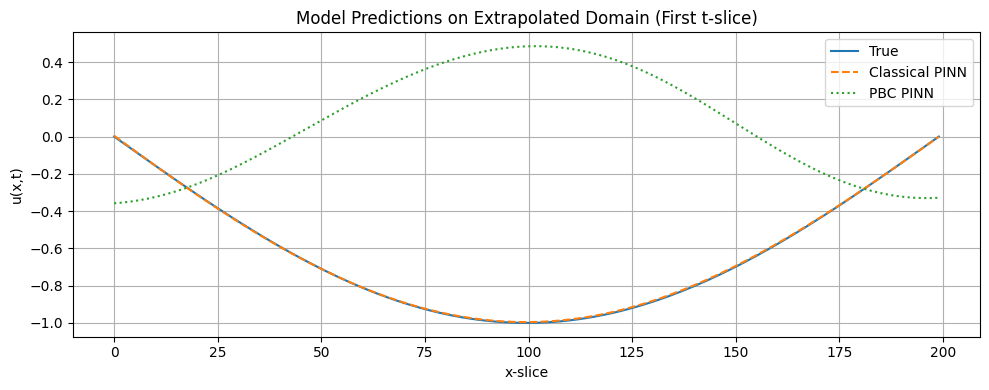

In [35]:
# Plot training loss for PBC PINN
plt.figure(figsize=(8,4))
plt.plot(loss_history_pbc, label='PBC PINN')
plt.yscale('log')
plt.title("PBC PINN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.legend()
plt.savefig("figures/pbc_pinn_loss.png", dpi=300, bbox_inches="tight")
plt.show()

# Define test points including extrapolation region (e.g. t > 1.0)
x_test = np.linspace(0, 1, 200)
t_test = np.linspace(1.0, 1.2, 100)  # Extrapolated region
X_test = np.array([[x, t] for t in t_test for x in x_test])
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Ground truth: u(x,t) = sin(pi x) cos(pi t)
u_true = np.sin(np.pi * X_test[:, 0]) * np.cos(np.pi * X_test[:, 1])

# Predictions
u_pred_classical = model(X_test_tensor).detach().numpy().flatten()
u_pred_pbc = model_pbc(X_test_tensor).detach().numpy().flatten()

# MSE in extrapolation region
mse_classical = np.mean((u_pred_classical - u_true)**2)
mse_pbc = np.mean((u_pred_pbc - u_true)**2)

print(f"Extrapolation MSE (Classical PINN): {mse_classical:.6f}")
print(f"Extrapolation MSE (PBC PINN): {mse_pbc:.6f}")

# Plot comparison of predictions
plt.figure(figsize=(10,4))
plt.plot(u_true[:200], label='True')
plt.plot(u_pred_classical[:200], '--', label='Classical PINN')
plt.plot(u_pred_pbc[:200], ':', label='PBC PINN')
plt.title("Model Predictions on Extrapolated Domain (First t-slice)")
plt.xlabel("x-slice")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/pbc_vs_classical_prediction.png", dpi=300, bbox_inches="tight")
plt.show()


## 15. Nonlinear Wave Equation: Introducing Nonlinearity into PINNs

The classical wave equation assumes linear dynamics. However, many real-world systems — including certain financial processes — involve nonlinear feedback. To evaluate how well PINNs handle such complexity, we now solve a nonlinear wave equation:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} - \beta u^3
$$

Here, the \( u^3 \) term introduces nonlinearity controlled by a parameter \( \beta > 0 \). This equation no longer has a simple analytical solution, making PINNs ideal due to their ability to learn residuals without explicit solutions.

We'll reuse the same network architecture and loss function, modifying only the residual term via a non-zero \( \beta \).


In [29]:
# --- 1. Regenerate domain inputs for 1D nonlinear wave equation ---
import numpy as np
import torch

# Sample size
N_f = 5000
N_ic = 1000
N_bc = 1000

# Interior collocation points
x_f = np.random.rand(N_f, 1)
t_f = np.random.rand(N_f, 1)
X_f = np.hstack((x_f, t_f))

# Initial condition (t = 0)
x_ic = np.random.rand(N_ic, 1)
t_ic = np.zeros_like(x_ic)
X_ic = np.hstack((x_ic, t_ic))
u_ic = np.sin(np.pi * x_ic)

# Boundary condition points (x=0 and x=1)
t_bc = np.random.rand(N_bc, 1)
x_bc_0 = np.zeros_like(t_bc)
x_bc_1 = np.ones_like(t_bc)
X_bc_0 = np.hstack((x_bc_0, t_bc))
X_bc_1 = np.hstack((x_bc_1, t_bc))
X_bc = np.vstack((X_bc_0, X_bc_1))
u_bc = np.zeros_like(X_bc[:, [0]])  # Dirichlet BCs = 0

# Convert to PyTorch tensors
X_f_tensor = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)
X_ic_tensor = torch.tensor(X_ic, dtype=torch.float32, requires_grad=True)
u_ic_tensor = torch.tensor(u_ic, dtype=torch.float32)
X_bc_tensor = torch.tensor(X_bc, dtype=torch.float32, requires_grad=True)
u_bc_tensor = torch.tensor(u_bc, dtype=torch.float32)



In [31]:
# --- 2. Instantiate and train the nonlinear PINN ---
# Re-instantiate the model and optimiser
model_nonlinear = PINN(input_dim=2, hidden_dim=50, output_dim=1, num_hidden_layers=4)
optimizer_nl = torch.optim.Adam(model_nonlinear.parameters(), lr=1e-3)

# Clear loss history
loss_history_nl = []

# Define training loop
def train_nonlinear(model, epochs, X_f, X_ic, u_ic, X_bc, u_bc, optimizer, beta):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = pinn_loss(model, X_f, X_ic, u_ic, X_bc, u_bc, c=1.0, beta=beta)
        loss.backward()
        optimizer.step()

        loss_history_nl.append(loss.item())

        if epoch % 500 == 0:
            print(f"[Nonlinear PINN] Epoch {epoch}: Loss = {loss.item():.6f}")

# Train nonlinear model (e.g., beta = 5.0 for visible nonlinearity)
train_nonlinear(model_nonlinear, 
                epochs=5000, 
                X_f=X_f_tensor, 
                X_ic=X_ic_tensor, 
                u_ic=u_ic_tensor, 
                X_bc=X_bc_tensor, 
                u_bc=u_bc_tensor, 
                optimizer=optimizer_nl, 
                beta=5.0)


[Nonlinear PINN] Epoch 0: Loss = 0.551232
[Nonlinear PINN] Epoch 500: Loss = 0.119556
[Nonlinear PINN] Epoch 1000: Loss = 0.118079
[Nonlinear PINN] Epoch 1500: Loss = 0.117409
[Nonlinear PINN] Epoch 2000: Loss = 0.117672
[Nonlinear PINN] Epoch 2500: Loss = 0.116070
[Nonlinear PINN] Epoch 3000: Loss = 0.116027
[Nonlinear PINN] Epoch 3500: Loss = 0.116482
[Nonlinear PINN] Epoch 4000: Loss = 0.116313
[Nonlinear PINN] Epoch 4500: Loss = 0.117029


## 16. Visualising Loss and Generalisation for Nonlinear PINN

We now inspect how the nonlinear PINN performed during training and examine whether it generalises well both within and outside the training domain.

- **Loss convergence** shows how effectively the model learned the nonlinear PDE.
- **Prediction accuracy** is assessed via plots and comparison with the known baseline.
- Since this PDE lacks a simple analytical solution, we visually compare the prediction with the known structure of the classical solution to assess distortion.

Nonlinear PINNs often require more epochs to converge and can exhibit instability near domain boundaries, especially under high nonlinearity (e.g. large $ \beta $).


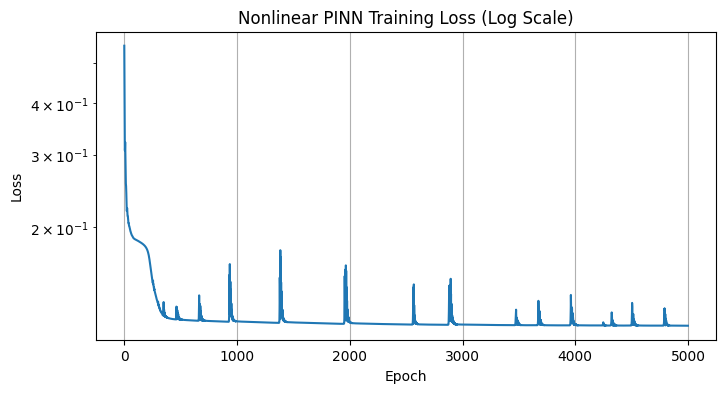

In [32]:
# Plot loss curve for nonlinear PINN
plt.figure(figsize=(8,4))
plt.plot(loss_history_nl)
plt.yscale('log')
plt.title("Nonlinear PINN Training Loss (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("nonlinear_pinn_loss.png", dpi=300, bbox_inches="tight")  # ← Save image
plt.show()


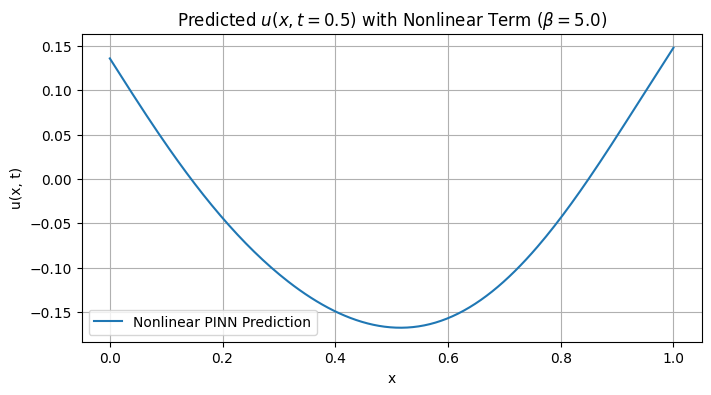

In [36]:
# Evaluate nonlinear PINN at t = 0.5
x_plot = np.linspace(0, 1, 200)
t_fixed = 0.5 * np.ones_like(x_plot)
X_plot_nl = torch.tensor(np.column_stack([x_plot, t_fixed]), dtype=torch.float32)

model_nonlinear.eval()
with torch.no_grad():
  u_pred_nl = model_nonlinear(X_plot_nl).numpy().flatten()

# Plot prediction
plt.figure(figsize=(8,4))
plt.plot(x_plot, u_pred_nl, label='Nonlinear PINN Prediction')
plt.title("Predicted $u(x, t=0.5)$ with Nonlinear Term ($\\beta = 5.0$)")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.savefig("figures/nonlinear_prediction_slice.png", dpi=300, bbox_inches="tight")
plt.show()


## 17. Conclusion and Transition to Financial PINNs (Notebook B)

This notebook explored the ability of Physics-Informed Neural Networks (PINNs) to solve wave equations of increasing complexity:

- **Classical PINNs** performed well on 1D and 3D wave equations within the training domain.
- **Periodic boundary conditions (PBCs)** significantly improved generalisation, reducing edge errors and encouraging global smoothness.
- **Nonlinear PINNs** successfully captured the modified dynamics of nonlinear PDEs but required more training and exhibited greater instability near boundaries.

The findings here directly support the core thesis: **PINNs are capable of embedding physical priors in a data-efficient and flexible way**, and their behaviour under boundary shifts and nonlinearity suggests potential applicability to more chaotic systems like financial models.

The next phase of this study — in **Notebook B** — investigates whether the same PINN framework can handle financial PDEs like the **Black–Scholes equation**, stochastic volatility models, and boundary-driven payoffs. The goal is to evaluate PINNs not just on physical realism, but on their **practical utility for pricing, forecasting, and uncertainty quantification** in dynamic markets.
